In [1]:
!pip install -q transformers matplotlib

In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

MODEL_NAME = 'Qwen/Qwen2.5-32B-Instruct'

device = 'cuda'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.padding_side = "left"
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map='auto',
    dtype=torch.float16,
    trust_remote_code=True
)
model.eval()

Loading checkpoint shards:   0%|          | 0/17 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 5120)
    (layers): ModuleList(
      (0-63): 64 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=True)
          (k_proj): Linear(in_features=5120, out_features=1024, bias=True)
          (v_proj): Linear(in_features=5120, out_features=1024, bias=True)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=5120, out_features=27648, bias=False)
          (up_proj): Linear(in_features=5120, out_features=27648, bias=False)
          (down_proj): Linear(in_features=27648, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((5120,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((5120,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((5120,), eps=1e-06)
    (

In [5]:
BATCH_SIZE = 128
PRED_PATH = 'predictions_vi.txt'
GD_PATH = 'public_test.en.txt'

In [6]:
def make_prompt(pred, tgt):
    prompt = f"""
You are an expert medical translator and evaluator.
Evaluate the quality of the predicted translation from Vietnamese to English (Prediction) compared with the reference translation (Ground Truth).
Provide only two numbers: Fluency and Adequacy, each on a 1-5 scale, separated by a space.
Fluency comes first, then Adequacy. Do NOT write anything else.
In medical translation, Adequacy (faithfulness) is especially important: ensure medical terms, dosages, conditions, and instructions are accurately translated.

Example 1:
Prediction: "The patient should take 2 paracetamol tablets daily."
Ground Truth: "The patient needs to take 2 paracetamol tablets every day."
Output: 5 5

Example 2:
Prediction: "Vaccinate before pregnancy."
Ground Truth: "Get vaccinated before becoming pregnant."
Output: 5 4

Now evaluate the following translation:

Prediction: "{pred}"
Ground Truth: "{tgt}"
Output:"""
    return prompt

In [7]:
fluencies = []
adequacies = []

with open(PRED_PATH, 'r', encoding='utf-8') as f:
    preds = f.read().splitlines()
with open(GD_PATH, 'r', encoding='utf-8') as f:
    tgts = f.read().splitlines()


def parse_output(text):
    try:
        text = text.split('Now evaluate the following translation:')[1].strip()
        text = text.split('Output:')[1].strip()
        fluency, adequacy = map(int, text.split()[:2])
    except:
        fluency, adequacy = -1, -1
    return fluency, adequacy


for i in tqdm(range(0, len(preds), BATCH_SIZE)):
    batch_preds = preds[i:i+BATCH_SIZE]
    batch_tgts = tgts[i:i+BATCH_SIZE]
    
    batch_prompts = [make_prompt(p, t) for p, t in zip(batch_preds, batch_tgts)]
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=8,
            do_sample=False
        )
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    for text in decoded:
        f, a = parse_output(text)
        fluencies.append(f)
        adequacies.append(a)

100%|██████████| 24/24 [03:30<00:00,  8.77s/it]


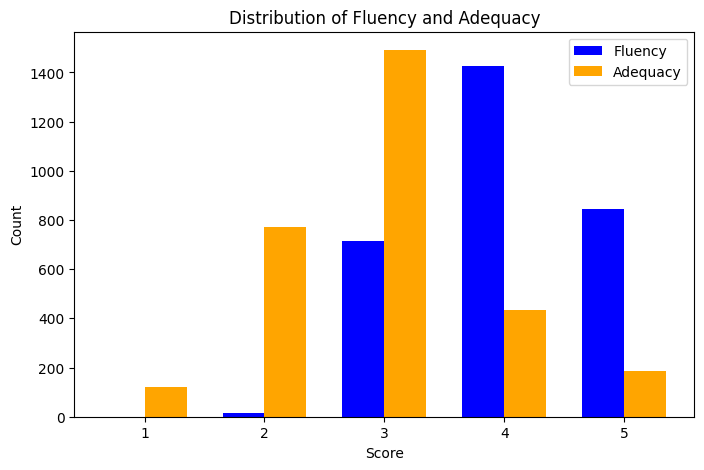

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

fluency_counts = [fluencies.count(i) for i in range(1,6)]
adequacy_counts = [adequacies.count(i) for i in range(1,6)]

x = range(1,6)
width = 0.35

plt.figure(figsize=(8,5))
plt.bar([i - width/2 for i in x], fluency_counts, width=width, label='Fluency', color='blue')
plt.bar([i + width/2 for i in x], adequacy_counts, width=width, label='Adequacy', color='orange')

plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Fluency and Adequacy')
plt.xticks(x)
plt.legend()
plt.show()

In [9]:
print(f'AVG Fluency: {sum(fluencies) / len(fluencies):.2f}')
print(f'AVG Adequacy: {sum(adequacies) / len(adequacies):.2f}')

AVG Fluency: 4.03
AVG Adequacy: 2.93


In [10]:
for i in range(len(adequacies)):
    if adequacies[i] == 1:
        print(f'Ground truth: {tgts[i]}')
        print(f'Prediction: {preds[i]}')
        print('-'*50)

Ground truth: Find the relationship between clinical, magnetic resonance, and anatomical femoral myopathy in patients with polymyositis and autoimmune dermatomyositis at the Department of Musculoskeletal - Bach Mai Hospital in the researched patients.
Prediction: To study the relationship between clinical features, magnetic resonance imaging and pathology of femoral muscle in this group.
--------------------------------------------------
Ground truth: Subjects and research Methods.
Prediction: Methods-Subjects.
--------------------------------------------------
Ground truth: Periodontal treatment improves glycosylatedhemoglobin.In
Prediction: Periodontal treatment helps lower blood glucose and vice versa, good glycemic control can improve periodontal disease.
--------------------------------------------------
Ground truth: Parental knowledge analysis of mothers treatment at the hospital of hospital Nam Dinh treasury
Prediction: Assessment of knowledge of mothers with children suffering